In [ ]:
# https://huggingface.co/ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing and processing audio signals.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# allows you to embed audio content directly in your notebook
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


import torch
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

In [ ]:
# Install required libraries for audio processing and evaluation metrics
!pip install git+https://github.com/huggingface/datasets.git
# !pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa
!pip install transformers[torch]

  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-eni0df1q
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets.git /tmp/pip-req-build-eni0df1q
  Resolved https://github.com/huggingface/datasets.git to commit 4200443045e694a045446950e8b235c7beb6239e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.6 MB/s eta 0:00:00
  Created wheel for datasets: filename=datasets-2.13.2.dev1-py3-none-any.whl size=492259 sha256=bb607d29996cb24dfe28ae52d6fe51d574b96e72803dddf98d378e88b8f1e07f
  Stored in directory: /tmp/pip-ephem-wheel-cache-n804v_j0/whe

In [ ]:
import datasets
import jiwer
import pkg_resources #By using pkg_resources.get_distribution("jiwer").version, you can retrieve the version of the jiwer library
import torchaudio
import librosa
import transformers



print("datasets version:", datasets.__version__)
print("jiwer version:", pkg_resources.get_distribution("jiwer").version)
print("torchaudio version:", torchaudio.__version__)
print("librosa version:", librosa.__version__)
print("transformers version:", transformers.__version__)

datasets version: 2.13.2.dev1
jiwer version: 3.0.2
torchaudio version: 2.0.2+cu118
librosa version: 0.10.0.post2
transformers version: 4.31.0


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/Mahdi_Javadi/Audio Analysis
%cd  /content/drive/MyDrive/Audio Analysis

/content/drive/MyDrive/Audio Analysis


In [ ]:
# Get the current working directory
cwd = os.getcwd()

# Get a list of all the files and directories in the current working directory
contents = os.listdir(cwd)

# Print the list of contents
print(contents)

['.config', 'drive', 'sample_data']


In [ ]:
# Ravdess = "/content/drive/MyDrive/Mahdi_Javadi/Audio Analysis/RAVDESS/audio_speech_actors_01-24/"
# Crema = "/content/drive/MyDrive/Mahdi_Javadi/Audio Analysis/CREMA-D/AudioWAV/"
# Tess = "/content/drive/MyDrive/Mahdi_Javadi/Audio Analysis/TESS/TESS Toronto emotional speech set data/"
# Savee = "/content/drive/MyDrive/Mahdi_Javadi/Audio Analysis/SAVEE/ALL/"


Ravdess = "/content/drive/MyDrive/Audio Analysis/RAVDESS/audio_speech_actors_01-24/"
Crema = "/content/drive/MyDrive/Audio Analysis/CREMA-D/AudioWAV/"
Tess = "/content/drive/MyDrive/Audio Analysis/TESS/TESS Toronto emotional speech set data/"
Savee = "/content/drive/MyDrive/Audio Analysis/SAVEE/ALL/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,sad,/content/drive/MyDrive/Audio Analysis/RAVDESS/...
1,sad,/content/drive/MyDrive/Audio Analysis/RAVDESS/...
2,angry,/content/drive/MyDrive/Audio Analysis/RAVDESS/...
3,angry,/content/drive/MyDrive/Audio Analysis/RAVDESS/...
4,calm,/content/drive/MyDrive/Audio Analysis/RAVDESS/...


In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/Audio Analysis/CREMA-D/...
1,happy,/content/drive/MyDrive/Audio Analysis/CREMA-D/...
2,sad,/content/drive/MyDrive/Audio Analysis/CREMA-D/...
3,neutral,/content/drive/MyDrive/Audio Analysis/CREMA-D/...
4,angry,/content/drive/MyDrive/Audio Analysis/CREMA-D/...


In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/Audio Analysis/TESS/TES...
1,angry,/content/drive/MyDrive/Audio Analysis/TESS/TES...
2,angry,/content/drive/MyDrive/Audio Analysis/TESS/TES...
3,angry,/content/drive/MyDrive/Audio Analysis/TESS/TES...
4,angry,/content/drive/MyDrive/Audio Analysis/TESS/TES...


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/Audio Analysis/SAVEE/AL...
1,angry,/content/drive/MyDrive/Audio Analysis/SAVEE/AL...
2,angry,/content/drive/MyDrive/Audio Analysis/SAVEE/AL...
3,angry,/content/drive/MyDrive/Audio Analysis/SAVEE/AL...
4,angry,/content/drive/MyDrive/Audio Analysis/SAVEE/AL...


In [ ]:
Ravdess_df.shape, Tess_df.shape, Savee_df.shape, Crema_df.shape

((1440, 2), (2800, 2), (480, 2), (7442, 2))

In [ ]:
from transformers import AutoConfig, Wav2Vec2Processor

In [ ]:
# Pretrained model and pooling mode

# model_name_or_path = "lighteternal/wav2vec2-large-xlsr-53-greek"
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
pooling_mode = "mean"

In [ ]:
# Load the Wav2Vec2 processor and extract the target sampling rate
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate

# Print the target sampling rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [ ]:
from tqdm import tqdm

tqdm.pandas()

def aa(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return len(speech)
Ravdess_df['speech_length'] = Ravdess_df['Path'].progress_apply(aa)

100%|██████████| 1440/1440 [07:47<00:00,  3.08it/s]


In [ ]:
Ravdess_df = Ravdess_df[Ravdess_df['speech_length'] > 1000]

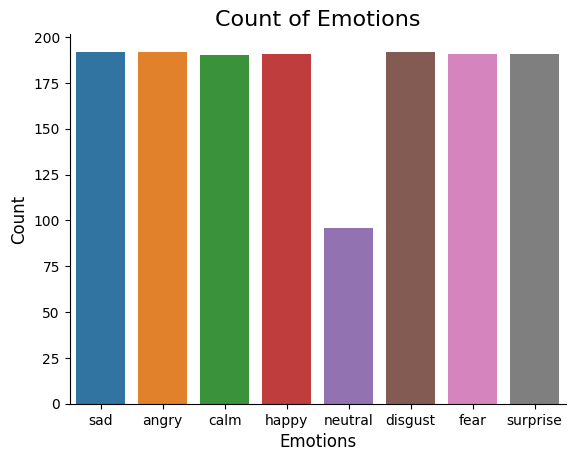

In [ ]:
plt.title('Count of Emotions', size=16)
# create a countplot using seaborn
sns.countplot(x='Emotions', data=Ravdess_df)
# sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # # without augmentation
    # res1 = extract_features(data)
    # result = np.array(res1)

    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data)
    # result = np.vstack((result, res2)) # stacking vertically

    # # data with stretching and pitching
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data)
    # res3 = extract_features(data_stretch_pitch)
    # result = np.vstack((result, res3)) # stacking vertically

    return data

In [ ]:
# Ravdess_df = Ravdess_df.sample(100, random_state=18)

Model

In [ ]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

In [ ]:
# save_path = "/content/drive/MyDrive/Mahdi_Javadi/wave2vec"
save_path = "/content/drive/MyDrive/Audio Analysis/wave2vec"

train_df1, test_df1 = train_test_split(Ravdess_df, test_size=0.2, random_state=101, stratify=Ravdess_df["Emotions"])
train_df2, test_df2 = train_test_split(Crema_df, test_size=0.2, random_state=101, stratify=Crema_df["Emotions"])
train_df3, test_df3 = train_test_split(Tess_df, test_size=0.2, random_state=101, stratify=Tess_df["Emotions"])
train_df4, test_df4 = train_test_split(Savee_df, test_size=0.2, random_state=101, stratify=Savee_df["Emotions"])

train_df = pd.concat([train_df1, train_df2, train_df3, train_df4])
test_df = pd.concat([test_df1, test_df2, test_df3, test_df4])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(9725, 3)
(2432, 3)


In [ ]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


# data_files = {
#     "train": "/content/drive/MyDrive/Mahdi_Javadi/wave2vec/train.csv",
#     "validation": "/content/drive/MyDrive/Mahdi_Javadi/wave2vec/test.csv",
# }

data_files = {
    "train": "/content/drive/MyDrive/Audio Analysis/wave2vec/train.csv",
    "validation": "/content/drive/MyDrive/Audio Analysis/wave2vec/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Emotions', 'Path', 'speech_length'],
    num_rows: 9725
})
Dataset({
    features: ['Emotions', 'Path', 'speech_length'],
    num_rows: 2432
})


In [ ]:
# We need to specify the input and output column
input_column = "Path"
output_column = "Emotions"

In [ ]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 8 classes: ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

In [ ]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]
    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1
)

Map:   0%|          | 0/9725 [00:00<?, ? examples/s]

Map:   0%|          | 0/2432 [00:00<?, ? examples/s]

RuntimeError: ignored

In [ ]:
/content/drive/MyDrive/Audio Analysis/TESS/TESS Toronto emotional speech set data/OAF_Fear/OAF_limb_fear.wav

In [ ]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['Emotions']}")

In [ ]:
train_dataset

In [ ]:
train_dataset.to_csv('/content/drive/MyDrive/Audio Analysis/wave2vec/train_dataset.csv', index=False)


## Model

Before diving into the training part, we need to build our classification model based on the merge strategy.

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
is_regression = False

In [ ]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

In [ ]:
model.freeze_feature_extractor()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    # output_dir="/content/drive/MyDrive/Mahdi_Javadi/wave2vec/wav2vec2-large-xlsr-53-english-speech-emotion-recognition",
    output_dir="/content/gdrive/MyDrive/wav2vec2-xlsr-english-speech-emotion-recognition",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=10,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
)

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        self.use_amp = 1
        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


In [ ]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

In [ ]:
trainer.train()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1938 in _inner_training_loop     │
│                                                                                                  │
│   1935 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1936 │   │   │   │                                                                             │
│   1937 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1938 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1939 │   │   │   │                                                                             │
│   1940 │   │   │   │   if (                                                                      │
│   1941 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│ in training_step:54                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'CTCTrainer' object has no attribute 'scaler'

## Evaluation

In [ ]:
import librosa
from sklearn.metrics import classification_report

In [ ]:
test_dataset = load_dataset("csv", data_files={"test": "/content/drive/MyDrive/Audio Analysis/wave2vec/test.csv"}, delimiter="\t")["test"]
test_dataset



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /content/cache/csv/default-dd5f248dc9e104d7/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['Emotions', 'Path', 'speech_length'],
    num_rows: 287
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
# model_name_or_path = "m3hrdadfi/wav2vec2-xlsr-greek-speech-emotion-recognition"
# config = AutoConfig.from_pretrained(model_name_or_path)
# processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
# model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

In [ ]:
!pip install resampy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.5 MB/s eta 0:00:00


In [ ]:
#The commented part gave an eroor ( positional argument had to be 1 but it was 3)

In [ ]:

# def speech_file_to_array_fn(batch):
#     speech_array, sampling_rate = torchaudio.load(batch["Path"])
#     speech_array = speech_array.squeeze().numpy()
#     speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

#     batch["speech"] = speech_array
#     return batch


import librosa

import resampy

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["Path"])
    speech_array = speech_array.squeeze().numpy()

    target_sampling_rate = 16000  # Replace with your desired target sampling rate

    speech_array = resampy.resample(speech_array, sampling_rate, target_sampling_rate)

    batch["speech"] = speech_array
    return batch





def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [ ]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

Map:   0%|          | 0/287 [00:00<?, ? examples/s]

In [ ]:
result = test_dataset.map(predict, batched=True, batch_size=8)

Map:   0%|          | 0/287 [00:00<?, ? examples/s]

In [ ]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
y_true = [config.label2id[name] for name in result["Emotions"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[5, 7, 4, 6, 6]
[5, 7, 4, 6, 6]


In [ ]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       angry       0.97      0.97      0.97        38
        calm       0.97      0.92      0.95        38
     disgust       1.00      0.97      0.99        39
        fear       0.97      0.95      0.96        38
       happy       0.93      1.00      0.96        38
     neutral       0.90      0.95      0.92        19
         sad       0.93      1.00      0.96        39
    surprise       1.00      0.92      0.96        38

    accuracy                           0.96       287
   macro avg       0.96      0.96      0.96       287
weighted avg       0.96      0.96      0.96       287

